In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')

import pandas as pd
import numpy as np
import pickle
import math
import sklearn
import glob,sys
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression
import proplot as plot

In [2]:
sys.path.insert(1,'../')
import preprocess
p1="../../timeseries_csv/ts_wp/"
p2="../../../targets/"

ds47=preprocess._process_dataset(glob.glob(p1+'*2010OMAIS*')[0])
tcwp47=ds47.values
var_names=ds47.columns.values.tolist()

In [3]:
from sklearn.metrics import r2_score,mean_squared_error
from natsort import natsorted
def depickle(loc=None):
    output = []
    with open(loc,'rb') as f:
        output.append(pickle.load(f))
    return output[0]

def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_strange_pred_aligned(TYPE='pmin',pred=None,truth=None):
    truth=np.asarray(truth)
    pred=np.asarray(pred)
    truth = truth[(pred>0) & (pred<10000)]
    pred = pred[(pred>0) & (pred<10000)]
    return truth,pred

def give_r2(filelocs='./WPAC/pcmci_2tau16/causalwpac_pmin_2tau16.obj.',
            suffix=str('*12348'),pc_alpha=[0.1]):
    store_r2train,store_r2test_old,store_r2test_new,store_size = [],[],[],[]
    #for pc_alpha in tqdm([0.01,0.05,0.07,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]):
    for pc_alpha in tqdm(pc_alpha):
        #filelist = sorted(glob.glob('./combinedscript/pickleddata2/12348/*pmin*.obj.0.2.*.12348'))
        filelistt =sorted(glob.glob(filelocs+str(pc_alpha)+suffix))[5::-1]+\
        sorted(glob.glob(filelocs+str(pc_alpha)+suffix))[6:]
        files = [depickle(obj) for obj in filelistt]
        temp_r2train = [r2_score(file['y']['train'],file['mlr'].predict(file['X']['train'])) for file in files]
        temp_r2test = [r2_score(file['y']['valid']+file['y']['test'],\
                                file['mlr'].predict(file['X']['valid']+file['X']['test'])) for file in files]
        temp = [np.asarray([list(obj) for obj in file['X']['train']]).shape[1] for file in files]
        store_r2train.append(temp_r2train)
        store_r2test.append(temp_r2test)
        store_size.append(temp)
    storedict_pcmci = {'r2_train':store_r2train,'r2_test':store_r2test,'size':store_size}
    del store_r2train,store_r2test,store_size
    return storedict_pcmci

def give_r2_pcstable(filelocs='./WPAC/pcstable_2tau16/newcausalwpac_2-16_pmin*',filelists=None):
    store_r2train,store_r2test_old,store_r2test_new,store_size = [],[],[],[]
    for pc_alpha in tqdm([0.2,0.1,0.05,0.01,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]):
        filelist = sorted(glob.glob(filelocs))
        files = [depickle(obj) for obj in filelist]
        temp_r2train = [r2_score(file['y']['train'],file['mlr'].predict(file['X']['train'])) for file in files]
        temp_r2test = [r2_score(file['y']['valid']+file['y']['test'],\
                                file['mlr'].predict(file['X']['valid']+file['X']['test'])) for file in files]
        temp = [np.asarray([list(obj) for obj in file['X']['train']]).shape[1] for file in files]
        store_r2train.append(temp_r2train)
        store_r2test.append(temp_r2test)
        store_size.append(temp)
    storedict_pcstable = {'r2_train':store_r2train,'r2_test':store_r2test,'size':store_size}
    del store_r2train,store_r2test,store_size
    return storedict_pcstable

def give_r2_aligned(filelist=None,modelname='mlr'):
    store_r2train,store_r2test_old,store_r2test_new,store_size = [],[],[],[]
    files = [depickle(obj) for obj in filelist]
    for file in tqdm(files):
        temp_r2train = r2_score(file['y']['train'],file[modelname].predict(file['X']['train']))
        temp_r2test_old = r2_score(file['y']['valid']+file['y']['test'],file[modelname].predict(file['X']['valid']+file['X']['test']))
        temp_r2test_new = r2_score(file['y']['newtest'],file[modelname].predict(file['X']['newtest']))
        temp = np.asarray([list(obj) for obj in file['X']['train']]).shape[1]
        store_r2train.append(temp_r2train)
        store_r2test_old.append(temp_r2test_old)
        store_r2test_new.append(temp_r2test_new)
        store_size.append(temp)
    storedict_pcstable = {'r2_train':store_r2train,'r2_test_old':store_r2test_old,'r2_test_new':store_r2test_new,'size':store_size}
    del store_r2train,store_r2test_old,store_r2test_new,store_size
    return storedict_pcstable

from sklearn.metrics import mean_squared_error,mean_absolute_error
def give_rmse_mae_aligned(filelist=None,TYPE='RMSE',modelname='mlr'):
    store_r2train,store_r2test_old,store_r2test_new,store_size = [],[],[],[]
    files = [depickle(obj) for obj in filelist]
    for file in files:
        if TYPE=='RMSE':
            temp_r2train = mean_squared_error(file['y']['train'],file[modelname].predict(file['X']['train']))
            temp_r2test_old = mean_squared_error(file['y']['valid']+file['y']['test'],file[modelname].predict(file['X']['valid']+file['X']['test']))
            temp_r2test_new = mean_squared_error(file['y']['newtest'],file[modelname].predict(file['X']['newtest']))
        elif TYPE=='MAE':
            temp_r2train = mean_absolute_error(file['y']['train'],file[modelname].predict(file['X']['train']))
            temp_r2test_old = mean_absolute_error(file['y']['valid']+file['y']['test'],file[modelname].predict(file['X']['valid']+file['X']['test']))
            temp_r2test_new = mean_absolute_error(file['y']['newtest'],file[modelname].predict(file['X']['newtest']))
        temp = np.asarray([list(obj) for obj in file['X']['train']]).shape[1]
        store_r2train.append(temp_r2train)
        store_r2test_old.append(temp_r2test_old)
        store_r2test_new.append(temp_r2test_new)
        store_size.append(temp)
    storedict_pcstable = {'train':store_r2train,'test_old':store_r2test_old,'test_new':store_r2test_new,'size':store_size}
    del store_r2train,store_r2test_old,store_r2test_new,store_size
    return storedict_pcstable

def give_r2_random(filelocs='./pickleddata_random/12348/randomwpall_2_16*pmin*'):
    random_files = sorted(glob.glob(filelocs))
    store_r2train,store_r2test_old,store_r2test_new,store_size = [],[],[],[]
    for pc_alpha in tqdm(range(len(random_files))):
        #filelist = sorted(glob.glob('./combinedscript/pickleddata2/12348/*pmin*.obj.0.2.*.12348'))
        files = [depickle(obj) for obj in random_files]
        temp_r2train = [r2_score(file['y']['train'],file['mlr'].predict(file['X']['train'])) for file in files]
        temp_r2test_old = [r2_score(file['y']['valid']+file['y']['test'],\
                                file['mlr'].predict(file['X']['valid']+file['X']['test'])) for file in files]
        temp_r2test_new = [r2_score(file['y']['newtest'],file['mlr'].predict(file['X']['newtest'])) for file in files]
        temp = [np.asarray([list(obj) for obj in file['X']['train']]).shape[1] for file in files]
        store_r2train.append(temp_r2train)
        store_r2test_old.append(temp_r2test_old)
        store_r2test_new.append(temp_r2test_new)
        storenatsort_size.append(temp)
    storedict_pcstable = {'r2_train':store_r2train,'r2_test_old':store_r2test_old,'r2_test_new':store_r2test_new,'size':store_size}
    del store_r2train,store_r2test_old,store_r2test_new,store_size
    return storedict_random

def give_r2_lag(filelocs='./pickleddata_lag/12348/lagwpacall8_24*pmin*'):
    fileslist = glob.glob(filelocs)[5::-1]+glob.glob(filelocs)[6:]
    files = [depickle(obj) for obj in fileslist]
    temp_r2train = [r2_score(file['y']['train'],file['mlr'].predict(file['X']['train'])) for file in files]
    temp_r2test_old = [r2_score(file['y']['valid']+file['y']['test'],file['mlr'].predict(file['X']['valid']+file['X']['test'])) for file in files]
    temp_r2test_new = [r2_score(file['y']['newtest'],file['mlr'].predict(file['X']['newtest'])) for file in files]
    temp = [np.asarray([list(obj) for obj in file['X']['train']]).shape[1] for file in files]
    storedict_lag = {'r2_train':temp_r2train,'r2_test_old':temp_r2test_old,'r2_test_new':temp_r2test_new,'size':temp}
    del temp_r2train,temp_r2test_old,temp_r2test_new
    return storedict_lag

def give_r2_anatsortligned_rf(filelist=None,alt_filelist=None):
    store_r2train,store_r2test_old,store_r2test_new,store_size = [],[],[],[]
    files = [depickle(obj) for obj in filelist]
    fileXy = [depickle(obj) for obj in alt_filelist]
    for ind,file in enumerate(files):
        temp_r2train = r2_score(fileXy[ind]['y']['train'],file.predict(fileXy[ind]['X']['train']))
        temp_r2test_old = r2_score(fileXy[ind]['y']['valid']+fileXy[ind]['y']['test'],file.predict(fileXy[ind]['X']['valid']+fileXy[ind]['X']['test']))
        temp_r2test_new = r2_score(fileXy[ind]['y']['newtest'],file.predict(fileXy[ind]['X']['newtest']))
        temp = np.asarray([list(obj) for obj in fileXy[ind]['X']['train']]).shape[1]
        store_r2train.append(temp_r2train)
        store_r2test_old.append(temp_r2test_old)
        store_r2test_new.append(temp_r2test_new)
        store_size.append(temp)
    storedict_pcstable = {'r2_train':store_r2train,'r2_test_old':store_r2test_old,'r2_test_new':store_r2test_new,'size':store_size}
    del store_r2train,store_r2test_old,store_r2test_new,store_size
    return storedict_pcstable

def give_rmse_mae_aligned_rf(filelist=None,TYPE='RMSE',alt_filelist=None):
    store_r2train,store_r2test_old,store_r2test_new,store_size = [],[],[],[]
    files = [depickle(obj) for obj in filelist]
    fileXy = [depickle(obj) for obj in alt_filelist]
    for ind,file in enumerate(files):
        if TYPE=='RMSE':
            temp_r2train = mean_squared_error(fileXy[ind]['y']['train'],file.predict(fileXy[ind]['X']['train']))
            temp_r2test_old = mean_squared_error(fileXy[ind]['y']['valid']+fileXy[ind]['y']['test'],file.predict(fileXy[ind]['X']['valid']+fileXy[ind]['X']['test']))
            temp_r2test_new = mean_squared_error(fileXy[ind]['y']['newtest'],file.predict(fileXy[ind]['X']['newtest']))
        elif TYPE=='MAE':
            temp_r2train = mean_absolute_error(fileXy[ind]['y']['train'],file.predict(fileXy[ind]['X']['train']))
            temp_r2test_old = mean_absolute_error(fileXy[ind]['y']['valid']+fileXy[ind]['y']['test'],file.predict(fileXy[ind]['X']['valid']+fileXy[ind]['X']['test']))
            temp_r2test_new = mean_absolute_error(fileXy[ind]['y']['newtest'],file.predict(fileXy[ind]['X']['newtest']))
        temp = np.asarray([list(obj) for obj in fileXy[ind]['X']['train']]).shape[1]
        store_r2train.append(temp_r2train)
        store_r2test_old.append(temp_r2test_old)
        store_r2test_new.append(temp_r2test_new)
        store_size.append(temp)
    storedict_pcstable = {'train':store_r2train,'test_old':store_r2test_old,'test_new':store_r2test_new,'size':store_size}
    del store_r2train,store_r2test_old,store_r2test_new,store_size
    return storedict_pcstable

## Figure 2

In [ ]:
pcstable_path = '/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/data/'
alpha_level = [float(obj.split('/')[-1].split('_')[-1][11-2:-6]) for obj in sorted(glob.glob(pcstable_path+'pcstablewpac*aligned_8-24*pmin*'))]
pmin_PC1models = [depickle(obj) for obj in sorted(glob.glob(pcstable_path+'pcstablewpac*aligned_8-24*pmin.obj.*'))]
PC1modelsize = [float(np.asarray(obj['X']['train']).shape[-1]) for obj in pmin_PC1models]

In [6]:
r2=[r2_score(obj['y']['valid']+obj['y']['test'],\
         obj['mlr'].predict(obj['X']['valid']+obj['X']['test'])) for obj in pmin_PC1models]

In [7]:
dff = pd.DataFrame({'alpha_level':np.asarray(alpha_level),'size':PC1modelsize,'r2':r2})
dff_sorted = dff.sort_values(by='alpha_level')

In [31]:
import rfreg_funcs
rfreg_funcs.save_to_pickle('./fig2_r2_824_pmin.pkl',dff)

## Comparison of pc and lag correlation

In [5]:
pcstable_path = '/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/data/'
for i in range(len(glob.glob(pcstable_path+'pcstablewpac*aligned_2-16*lag*'))):
    print(len([(list(obj)[0]) for obj in depickle(sorted(glob.glob(pcstable_path+'pcstablewpac*aligned_2-16*lag*'))[i])[0]]))

18
18
21
23
26
26
27
29
30
34
34
36
38
38
38
42
47
53
61
72
78
83
88
96
106
114
144
160
182
233
239
259
279
16
14
16
13
10


In [12]:
from natsort import natsorted

In [13]:
list1 = [list(obj)[0] for obj in depickle(natsorted(glob.glob('./pickleddata_lag/12348/lagwpacall2_16*lag*'))[12])[1]]
list2 = [list(obj)[0] for obj in depickle(sorted(glob.glob(pcstable_path+'/pcstablewpac*aligned_2-16*lag*'))[-10])[1]]

In [14]:
list2 = [list(obj)[0] for obj in depickle(sorted(glob.glob(pcstable_path+'/pcstablewpac*aligned_2-16*lag*'))[-10])[1]]

In [82]:
for i in list((set(list1).intersection(list2))):
    print(var_names[i])

outtot_wtr_vpr
pmin
wind10
vi_div_moisture_flux
vvel_400
vvel_500
vvel_850
div_925
div_1000
vvel_925
tot_suprcool_liqwtr
tot_wtr_vpr
eqt300
eqt500
outvvel_300
tot_cld_rain


In [83]:
for i in list((set(list2))-(set(list1).intersection(list2))):
    print(var_names[i])

div_50
div_100
div_200
div_300
div_500
div_600
div_700
div_800
div_850
2mdewtmp
tot_cldwtr
vi_div_mass_flux
vi_div_tot_enrgy_flux
vi_pe_ie_latentenrgy
vi_tot_enrgy
cape
inst_moisture_flux
inst_ssh_flux
surfmean_shf
surf_shf
sst
rhum_150
rhum_250
rhum_800
rhum_850
rhum_975
rhum_1000
gpot_100
gpot_500
gpot_600
gpot_700
gpot_800
gpot_900
gpot_925
gpot_950
gpot_975
gpot_1000
vvel_100
vvel_300
vvel_975
vvel_1000
outdiv_50
outdiv_100
outdiv_300
outdiv_700
outdiv_850
outdiv_925
outeqt300
outeqt400
outeqt500
outeqt700
outeqt850
outvi_div_cld_froz_wtr
outvi_div_cld_liq_wtr
outvi_div_moisture_flux
outcape
outinst_ssh_flux
outvort_800
outvort_975
outvort_1000
outrhum_200
outrhum_600
outrhum_800
outrhum_975
outrhum_1000
outgpot_400
outvvel_100
outvvel_150
outvvel_975
outvvel_1000
shear_850_250


In [84]:
for i in list((set(list1))-(set(list1).intersection(list2))):
    print(var_names[i])

tot_Prec_Intg
vi_moisture_div
outtot_cld_ice
vvel_600
outtot_cld_rain
vvel_700
vimean_moisture_div
eqt400
outvvel_200
eqt600
outvvel_250


#### Reading pcstable and pcmci - aligned files

In [105]:
X_new,y_new = remove_999_in_aligned(fileobjs=objs,TYPE='test')

In [230]:
lag_and_var = depickle(sorted(glob.glob(pcstable_path+'pcstablewpac*aligned_8-24*lag*1e-06*'))[0])[1]
for i in lag_and_var:
    varnameindex = list(i)[0]
    print(var_names[varnameindex])

pmin
inst_ssh_flux
pmin
outvi_tot_enrgy
vvel_1000
outvi_pe_ie_latentenrgy
tot_cld_rain
cape
outvi_tot_enrgy
outvvel_300
vi_div_mass_flux
outrhum_1000
outdiv_400
div_600
outvort_1000
tot_wtr_vpr
outdiv_925
outvort_1000


In [4]:
#####################################################################################################################################
# Read files (PC1)
listtt = (sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/pcstablewpac*aligned_8-24*v10*')))
# Wrong order to correct...
aligned2_16_list = [listtt[-1],listtt[-4],listtt[-2],listtt[-5],listtt[-3],listtt[-6]]
for obj in listtt[:-6]:
    aligned2_16_list.append(obj)
#####################################################################################################################################    
#pcmci_wpac_2tau16 = give_r2()
pcstable_wpac_2tau16 = give_r2_aligned(aligned2_16_list)

In [39]:
rmse_wpac_2tau16 = give_rmse_mae_aligned(aligned2_16_list,'RMSE')
mae_wpac_2tau16 = give_rmse_mae_aligned(aligned2_16_list,'MAE')

In [40]:
r2_df = pd.DataFrame({'train':np.asarray(pcstable_wpac_2tau16['r2_train']).flatten(),'test':np.asarray(pcstable_wpac_2tau16['r2_test']).flatten(),'name':aligned2_16_list})
rmse_df = pd.DataFrame({'train':np.asarray(rmse_wpac_2tau16['train']).flatten(),'test':np.asarray(rmse_wpac_2tau16['test']).flatten(),'name':aligned2_16_list})
mae_df = pd.DataFrame({'train':np.asarray(mae_wpac_2tau16['train']).flatten(),'test':np.asarray(mae_wpac_2tau16['test']).flatten(),'name':aligned2_16_list})

In [41]:
maxr2 = np.asarray(pcstable_wpac_2tau16['r2_test']).max()
index_r2_best,index_r2_1percent = r2_df['test'].idxmax(),r2_df[r2_df['test']>maxr2-maxr2*0.01].index
index_r2_best
#import rfreg_funcs
#rfreg_funcs.save_to_pickle('./tmp/multimodelnames_fig4.pkl',list(r2_df.iloc[index_r2_1percent]['name'].values))

10

In [81]:
import rfreg_funcs
lag_wpac_2tau16 = give_r2_lag('./pickleddata_lag/12348/lagwpacall8_24*v10*')
storelag = {'filename':glob.glob('./pickleddata_lag/12348/lagwpacall8_24*v10*')[5::-1]+glob.glob('./pickleddata_lag/12348/lagwpacall8_24*v10*')[6:],
            'r2_test': lag_wpac_2tau16['r2_test'],'r2_train':lag_wpac_2tau16['r2_train']}
print(index_r2_best)
#rfreg_funcs.save_to_pickle('./tmp/multimodelnames_fig4_lag.pkl',list(df_lag.iloc[index_r2_1percent]['filename'].values))

31


#### Random Feature Selection MLR

In [7]:
! pwd

/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1


In [4]:
def output_performance_r2(listt=None,var='R2',TYPE='MLR',listtt_mlr=None,modelname='mlr'):
    if var=='R2':
        if TYPE=='MLR':
            files = give_r2_aligned(listt,modelname)
        elif TYPE=='RF':
            from natsort import natsorted
            #####################################################################################################################################
            # Read files (PC1)
            #listtt = sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/rf/*pmin*'))
            # Wrong order to correct...
            aligned2_16_list = [listt[-1],listt[-4],listt[-2],listt[-5],listt[-3],listt[-6]]
            for obj in listt[:-6]:
                aligned2_16_list.append(obj)
            #####################################################################################################################################
            # Read files (PC1)
            #listtt_mlr = (sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/pcstablewpac_aligned_8-24_pmin*')))
            # Wrong order to correct...
            aligned2_16_list_mlr = [listtt_mlr[-1],listtt_mlr[-4],listtt_mlr[-2],listtt_mlr[-5],listtt_mlr[-3],listtt_mlr[-6]]
            for obj in listtt_mlr[:-6]:
                aligned2_16_list_mlr.append(obj)
            #####################################################################################################################################
            files = give_r2_aligned_rf(aligned2_16_list,aligned2_16_list_mlr)
        storelag = {'filename':listt,'r2_test_new': files['r2_test_new'],'r2_train':files['r2_train'],'r2_valid':files['r2_test_old']}
        r2_df = pd.DataFrame({'train':np.asarray(storelag['r2_train']).flatten(),\
                              'test':np.asarray(storelag['r2_test_new']).flatten(),\
                              'valid':np.asarray(storelag['r2_valid']).flatten(),\
                              'name':storelag['filename']})
        df_lag = pd.DataFrame(storelag)
        maxr2 = np.asarray(df_lag['r2_valid']).max()
        index_r2_best,index_r2_1percent = df_lag['r2_valid'].idxmax(),df_lag[df_lag['r2_valid']>maxr2-maxr2*0.10].index
        return storelag,float(r2_df.iloc[index_r2_best]['train']), float(r2_df.iloc[index_r2_best]['valid']), float(r2_df.iloc[index_r2_best]['test']),\
    float(np.asarray(files['size'])[index_r2_best])

def output_performance_mae_rmse(listt=None,var='RMSE',TYPE='MLR',listtt_mlr=None,modelname='mlr',r2dict=None):
    if var=='MAE':
        if TYPE=='MLR':
            files = give_rmse_mae_aligned(listt,var,modelname)
        elif TYPE=='RF':
            from natsort import natsorted
            #####################################################################################################################################
            # Read files (PC1)
            #listtt = sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/rf/*pmin*'))
            # Wrong order to correct...
            aligned2_16_list = [listt[-1],listt[-4],listt[-2],listt[-5],listt[-3],listt[-6]]
            for obj in listt[:-6]:
                aligned2_16_list.append(obj)
            #####################################################################################################################################
            # Read files (PC1)
            #listtt_mlr = (sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/pcstablewpac_aligned_8-24_pmin*')))
            # Wrong order to correct...
            aligned2_16_list_mlr = [listtt_mlr[-1],listtt_mlr[-4],listtt_mlr[-2],listtt_mlr[-5],listtt_mlr[-3],listtt_mlr[-6]]
            for obj in listtt_mlr[:-6]:
                aligned2_16_list_mlr.append(obj)
            #####################################################################################################################################
            files = give_rmse_mae_aligned_rf(aligned2_16_list,var,aligned2_16_list_mlr)
        r2_df = pd.DataFrame({'r2_train':np.asarray(r2dict['r2_train']).flatten(),'r2_valid':np.asarray(r2dict['r2_valid']).flatten(),\
                              'r2_test':np.asarray(r2dict['r2_test_new']).flatten(),'name':listt})
        mae_df = pd.DataFrame({'train':np.asarray(files['train']).flatten(),'valid':np.asarray(files['test_old']).flatten(),\
                               'test':np.asarray(files['test_new']).flatten(),'name':listt})
        df_lag = pd.DataFrame(r2_df)
        maxr2 = np.asarray(df_lag['r2_valid']).max()
        index_r2_best = df_lag['r2_valid'].idxmax()
        return float(mae_df.iloc[index_r2_best]['train']),float(mae_df.iloc[index_r2_best]['valid']),\
    float(mae_df.iloc[index_r2_best]['test']),float(np.asarray(files['size'])[index_r2_best])
    
    elif var=='RMSE':
        if TYPE=='MLR':
            files = give_rmse_mae_aligned(listt,var,modelname)
        elif TYPE=='RF':
            from natsort import natsorted
            #####################################################################################################################################
            # Read files (PC1)
            #listtt = sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/rf/*pmin*'))
            # Wrong order to correct...
            aligned2_16_list = [listt[-1],listt[-4],listt[-2],listt[-5],listt[-3],listt[-6]]
            for obj in listt[:-6]:
                aligned2_16_list.append(obj)
            #####################################################################################################################################
            # Read files (PC1)
            #listtt_mlr = (sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/pcstablewpac_aligned_8-24_pmin*')))
            # Wrong order to correct...
            aligned2_16_list_mlr = [listtt_mlr[-1],listtt_mlr[-4],listtt_mlr[-2],listtt_mlr[-5],listtt_mlr[-3],listtt_mlr[-6]]
            for obj in listtt_mlr[:-6]:
                aligned2_16_list_mlr.append(obj)
            #####################################################################################################################################
            files = give_rmse_mae_aligned_rf(aligned2_16_list,var,aligned2_16_list_mlr)
        r2_df = pd.DataFrame({'r2_train':np.asarray(r2dict['r2_train']).flatten(),'r2_valid':np.asarray(r2dict['r2_valid']).flatten(),\
                              'r2_test':np.asarray(r2dict['r2_test_new']).flatten(),'name':listt})
        rmse_df = pd.DataFrame({'train':np.asarray(files['train']).flatten(),'valid':np.asarray(files['test_old']).flatten(),\
                               'test':np.asarray(files['test_new']).flatten(),'name':listt})
        df_lag = pd.DataFrame(r2_df)
        maxr2 = np.asarray(df_lag['r2_valid']).max()
        index_r2_best = df_lag['r2_valid'].idxmax()
        return float(rmse_df.iloc[index_r2_best]['train']),float(rmse_df.iloc[index_r2_best]['valid']),\
    float(rmse_df.iloc[index_r2_best]['test']),float(np.asarray(files['size'])[index_r2_best])
    
def storeRMSE(path_prefix=None,TYPE='MLR',storename='mlr',alt_fileprefix=None,natsortted='No'):
    storeRMSE = []
    for target in ['pmin','v10','precip']:
        #filelist = glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/lag/12348/lagwpac*8_24*'+str(target)+'.obj.*')
        if natsortted=='Yes':
            listtt_lag = natsorted(glob.glob(path_prefix+str(target)+'.obj.*'))
        elif natsortted=='No':
            listtt_lag = sorted(glob.glob(path_prefix+str(target)+'.obj.*'))            
        if TYPE=='MLR':
            storer2,_,_,_,_ = output_performance_r2(listtt_lag,'R2',TYPE,None,storename)
            train,valid,test,_ = output_performance_mae_rmse(listtt_lag,'RMSE',TYPE,None,storename,storer2)
        elif TYPE=='RF':
            alt_filelist = sorted(glob.glob(alt_fileprefix+str(target)+'*'))
            storer2,_,_,_,_ = output_performance_r2(listtt_lag,'R2',TYPE,alt_filelist,storename)
            train,valid,test,_ = output_performance_mae_rmse(listtt_lag,'RMSE',TYPE,alt_filelist,storename,storer2)            
        if target=='precip':
            storeRMSE.append([train/1000,valid/1000,test/1000])
        else:
            storeRMSE.append([train,valid,test])
    return [np.round(obj,decimals=2) for obj in np.ravel(np.asarray(storeRMSE),'F')]

def storeMAE(path_prefix=None,TYPE='MLR',storename='mlr'):
    storeMAE = []
    for target in ['pmin','v10','precip']:
        #filelist = glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/lag/12348/lagwpac*8_24*'+str(target)+'.obj.*')
        listtt_lag = natsorted(glob.glob(path_prefix+str(target)+'.obj.*'))
        if TYPE=='MLR':
            storer2,_,_,_,_ = output_performance_r2(listtt_lag,'R2',TYPE,None,storename)
            train,valid,test,_ = output_performance_mae_rmse(listtt_lag,'MAE',TYPE,None,storename,storer2)
        elif TYPE=='RF':
            storer2,_,_,_,_ = output_performance_r2(listtt_lag,'R2',TYPE,alt_filelist,storename)
            train,valid,test,_ = output_performance_mae_rmse(listtt_lag,'MAE',TYPE,alt_filelist,storename,storer2)  
        if target=='precip':
            storeMAE.append([train/1000,valid/1000,test/1000])
        else:
            storeMAE.append([train,valid,test])
    return [np.round(obj,decimals=2) for obj in np.ravel(np.asarray(storeMAE),'F')]

In [112]:
# random (start from 9)
listtt = (natsorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/random_rf/randomrf_8-24*v10.obj.*')))[9:]
listtt_mlr = (natsorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/random/12348/randomwp*8_24_v10*')))[9:]
storer2,train_r2,valid_r2,test_r2,size = output_performance_r2(listtt,'R2','RF',listtt_mlr,'model')

In [113]:
train_r2,valid_r2,test_r2,size

(0.9292547666305121, 0.7679355368775268, 0.765194226976501, 770.0)

## Creating Array for MSE - noncausal MLR

In [ ]:
All=/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/noncausal/12348/*precip*
lagged=/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/lag/12348/lagwpac*8_24*precip.obj.*
random=/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/random/12348/random*8_24_precip.obj.*
xai=/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/rf_feature/12348/rfredall8_24_precip.obj.*

In [104]:
allmodl = []
for target in ['pmin','v10','precip']:
    model = depickle(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/noncausal/12348/*'+str(target)+'*')[0])
    if target=='precip':
        allmodl.append([mean_squared_error(model['y']['train'],model['mlr'].predict(model['X']['train']))/1000,\
                        mean_squared_error(model['y']['valid']+model['y']['test'],model['mlr'].predict(model['X']['valid']+model['X']['test']))/1000,\
                        mean_squared_error(model['y']['newtest'],model['mlr'].predict(model['X']['newtest']))/1000])
    else:
        allmodl.append([mean_squared_error(model['y']['train'],model['mlr'].predict(model['X']['train'])),\
                        mean_squared_error(model['y']['valid']+model['y']['test'],model['mlr'].predict(model['X']['valid']+model['X']['test'])),\
                        mean_squared_error(model['y']['newtest'],model['mlr'].predict(model['X']['newtest']))])

In [93]:
laglist = storeRMSE('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/lag/12348/lagwpac*8_24*')
randomlist = storeRMSE('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/random/12348/random*8_24*')
xailist = storeRMSE('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/rf_feature/12348/rfregall8_24*')

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [207]:
mlr_fileprefix = '/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/pcstablewpac*8-24_*'
causal_rf = storeRMSE('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/rf/rfmodels_8-24_*','RF','model',mlr_fileprefix,'No')
#causal_mlr = storeRMSE('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/pcstablewpac*8-24_*')
#lstm = storeRMSE('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/best_lstm/best_model3*')

In [209]:
import rfreg_funcs
rfreg_funcs.save_to_pickle('./store/rmse_mae/storestuff_causalrf_rmse.pkl',causal_rf)

In [ ]:
noncausal_rf=
rf_lagged='/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/lag_rf/randomrf_8-24*v10.obj.*'
rf_random='/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/random_rf/randomrf_8-24*v10.obj.*'

In [140]:
def handle_lines(prefix=None,numbers=None):
    for obj in [np.round(obj, decimals=2) for obj in list(numbers)]:
        tofill = str(obj)+" & "
        prefix+=tofill
    return prefix

In [138]:
alllist = [np.round(obj,decimals=2) for obj in np.ravel(np.asarray(allmodl),'F')]
storestuff = np.vstack([np.asarray(obj) for obj in [alllist,laglist,randomlist,xailist]])

In [147]:
import rfreg_funcs
rfreg_funcs.save_to_pickle('./store/rmse_mae/storestuff_noncausalmlr_rmse.pkl',storestuff)

In [144]:
path = './testtable_rmse_noncausal_mlr.txt'
f= open(path,"w+")
f.write("\\begin{table}\n")
f.write("\\begin{centering}\n")
f.write("\\begin{tabular}{cc|c|c|c|c|c|c|c|c|c|c}\n")
f.write("\\multicolumn{2}{c}{ML Models} & \multicolumn{3}{c}{Training} & \multicolumn{3}{c}{Validation} & \multicolumn{3}{c|}{Test } & \\tabularnewline")
f.write("\\hline\n")

sentence1 = "\\multicolumn{2}{c|}{\\textbf{Target}} & Pmin (hPa)\\textcolor{purple}{{} } & V10 (m/s) & Precip (km\\textasciicircum 3) & Pmin (hPa)\\textcolor{purple}{{} } & V10 (m/s) & "+\
"Precip (km\\textasciicircum 3) & Pmin (hPa)\\textcolor{purple}{{} } & V10 (m/s) & Precip (km\\textasciicircum 3) & \\tabularnewline "+\
"\cline{3-12} \cline{4-12} \cline{5-12} \cline{6-12} \cline{7-12} \cline{8-12} \cline{9-12} \cline{10-12} \cline{11-12} \cline{12-12}\n"
f.write(sentence1)
f.write(handle_lines('\\multicolumn{2}{c|}{\\textbf{Causal RF}} & ' ,storestuff[0,:])+"\\tabularnewline\n")
f.write(handle_lines('\\multirow{4}{*}{\\textbf{Non-causal MLR}} & All & ',storestuff[0,:])+"\\tabularnewline\n")
f.write(handle_lines('\cline{2-12} \cline{3-12} \cline{4-12} \cline{5-12} \cline{6-12} \cline{7-12} \cline{8-12} \cline{9-12} \cline{10-12} \cline{11-12} \cline{12-12} & Lagged & ',
                     storestuff[1,:])+"\\tabularnewline\n")
f.write(handle_lines('\cline{2-12} \cline{3-12} \cline{4-12} \cline{5-12} \cline{6-12} \cline{7-12} \cline{8-12} \cline{9-12} \cline{10-12} \cline{11-12} \cline{12-12} & Random & ',
                     storestuff[2,:])+"\\tabularnewline\n")
f.write(handle_lines('\cline{2-12} \cline{3-12} \cline{4-12} \cline{5-12} \cline{6-12} \cline{7-12} \cline{8-12} \cline{9-12} \cline{10-12} \cline{11-12} \cline{12-12} & XAI & ',
                     storestuff[3,:])+"\\tabularnewline\n")
f.write("\\hline\n")
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}\n")
f.write("\\end{table}")
f.close()
print('Table printed to',path)

Table printed to ./testtable.txt


In [153]:
laglistMAE = storeMAE('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/lag/12348/lagwpac*8_24*')
randomlistMAE = storeMAE('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/random/12348/random*8_24*')
xailistMAE = storeMAE('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/rf_feature/12348/rfregall8_24*')

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [154]:
allmodlMAE = []
for target in ['pmin','v10','precip']:
    model = depickle(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/noncausal/12348/*'+str(target)+'*')[0])
    if target=='precip':
        allmodlMAE.append([mean_absolute_error(model['y']['train'],model['mlr'].predict(model['X']['train']))/1000,\
                        mean_absolute_error(model['y']['valid']+model['y']['test'],model['mlr'].predict(model['X']['valid']+model['X']['test']))/1000,\
                        mean_absolute_error(model['y']['newtest'],model['mlr'].predict(model['X']['newtest']))/1000])
    else:
        allmodlMAE.append([mean_absolute_error(model['y']['train'],model['mlr'].predict(model['X']['train'])),\
                        mean_absolute_error(model['y']['valid']+model['y']['test'],model['mlr'].predict(model['X']['valid']+model['X']['test'])),\
                        mean_absolute_error(model['y']['newtest'],model['mlr'].predict(model['X']['newtest']))])

In [155]:
alllistMAE = [np.round(obj,decimals=2) for obj in np.ravel(np.asarray(allmodlMAE),'F')]
storestuffMAE = np.vstack([np.asarray(obj) for obj in [alllistMAE,laglistMAE,randomlistMAE,xailistMAE]])

In [157]:
rfreg_funcs.save_to_pickle('./store/rmse_mae/storestuff_noncausalmlr_mae.pkl',storestuffMAE)

##### Performance Table

###### v10

V10

In [122]:
print(f"Best model and number of inputs:{float(rmse_df.iloc[index_r2_best]['test']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
print(f"Models within 1percent of best:{np.asarray(rmse_df.iloc[index_r2_1percent]['test']).mean()}")
print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['test'].values),25),np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['test']),75)}")
print("---r2---")
print(f"Best model and number of inputs:{float(r2_df.iloc[index_r2_best]['test']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
print(f"Models within 1percent of best:{np.asarray(r2_df.iloc[index_r2_1percent]['test']).mean()}")
print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['test']),25),np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['test']),75)}")

#print(f"Best model and number of inputs:{float(rmse_df.iloc[index_r2_best]['train']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
#print(f"Models within 1percent of best:{np.asarray(rmse_df.iloc[index_r2_1percent]['train']).mean()}")
#print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['train'].values),25),np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['train']),75)}")
#print("---r2---")
#print(f"Best model and number of inputs:{float(r2_df.iloc[index_r2_best]['train']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
#print(f"Models within 1percent of best:{np.asarray(r2_df.iloc[index_r2_1percent]['train']).mean()}")
#print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['train']),25),np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['train']),75)}")

Best model and number of inputs:(6.397917986077635, 60.0)
Models within 1percent of best:7.454557747315737
Quantile range with 1percent of best:(6.90975548655824, 8.096895283447763)
---r2---
Best model and number of inputs:(0.8096182233655386, 60.0)
Models within 1percent of best:0.7779042960156741
Quantile range with 1percent of best:(0.7590620397697497, 0.7943875603745958)


In [123]:
print(f"Best model and number of inputs:{float(mae_df.iloc[index_r2_best]['test']),float(np.asarray(mae_wpac_2tau16['size'])[index_r2_best])}")
print(f"Models within 1percent of best:{np.asarray(mae_df.iloc[index_r2_1percent]['test']).mean()}")
print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['test']),25),np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['test']),75)}")

#print(f"Best model and number of inputs:{float(mae_df.iloc[index_r2_best]['train']),float(np.asarray(mae_wpac_2tau16['size'])[index_r2_best])}")
#print(f"Models within 1percent of best:{np.asarray(mae_df.iloc[index_r2_1percent]['train']).mean()}")
#print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['train']),25),np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['train']),75)}")

Best model and number of inputs:(1.9616893311115469, 60.0)
Models within 1percent of best:2.1183040938663558
Quantile range with 1percent of best:(2.0592896461184527, 2.1903924569372424)


###### pmin

In [113]:
#print(f"Best model and number of inputs:{float(rmse_df.iloc[index_r2_best]['test']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
#print(f"Models within 1percent of best:{np.asarray(rmse_df.iloc[index_r2_1percent]['test']).mean()}")
#print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['test'].values),25),np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['test']),75)}")
#print("---r2---")
#print(f"Best model and number of inputs:{float(r2_df.iloc[index_r2_best]['test']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
#print(f"Models within 1percent of best:{np.asarray(r2_df.iloc[index_r2_1percent]['test']).mean()}")
#print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['test']),25),np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['test']),75)}")

print(f"Best model and number of inputs:{float(rmse_df.iloc[index_r2_best]['train']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
print(f"Models within 1percent of best:{np.asarray(rmse_df.iloc[index_r2_1percent]['train']).mean()}")
print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['train'].values),25),np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['train']),75)}")
print("---r2---")
print(f"Best model and number of inputs:{float(r2_df.iloc[index_r2_best]['train']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
print(f"Models within 1percent of best:{np.asarray(r2_df.iloc[index_r2_1percent]['train']).mean()}")
print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['train']),25),np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['train']),75)}")

Best model and number of inputs:(10.396934383328459, 1080.0)
Models within 1percent of best:14.868912671947726
Quantile range with 1percent of best:(12.279401345637115, 16.713554159182085)
---r2---
Best model and number of inputs:(0.9499491299330864, 1080.0)
Models within 1percent of best:0.9284210144315933
Quantile range with 1percent of best:(0.9195409053538972, 0.940886928916713)


In [114]:
#print(f"Best model and number of inputs:{float(mae_df.iloc[index_r2_best]['test']),float(np.asarray(mae_wpac_2tau16['size'])[index_r2_best])}")
#print(f"Models within 1percent of best:{np.asarray(mae_df.iloc[index_r2_1percent]['test']).mean()}")
#print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['test']),25),np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['test']),75)}")

print(f"Best model and number of inputs:{float(mae_df.iloc[index_r2_best]['train']),float(np.asarray(mae_wpac_2tau16['size'])[index_r2_best])}")
print(f"Models within 1percent of best:{np.asarray(mae_df.iloc[index_r2_1percent]['train']).mean()}")
print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['train']),25),np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['train']),75)}")

Best model and number of inputs:(2.471213875534776, 1080.0)
Models within 1percent of best:2.889538857228964
Quantile range with 1percent of best:(2.6739524063286813, 3.065753537237964)


###### precip

In [106]:
#print(f"Best model and number of inputs:{float(rmse_df.iloc[index_r2_best]['test']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
#print(f"Models within 1percent of best:{np.asarray(rmse_df.iloc[index_r2_1percent]['test']).mean()}")
#print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['test'].values),25),np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['test']),75)}")
#print("---r2---")
#print(f"Best model and number of inputs:{float(r2_df.iloc[index_r2_best]['test']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
#print(f"Models within 1percent of best:{np.asarray(r2_df.iloc[index_r2_1percent]['test']).mean()}")
#print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['test']),25),np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['test']),75)}")

print(f"Best model and number of inputs:{float(rmse_df.iloc[index_r2_best]['train']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
print(f"Models within 1percent of best:{np.asarray(rmse_df.iloc[index_r2_1percent]['train']).mean()}")
print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['train'].values),25),np.percentile(np.asarray(rmse_df.iloc[index_r2_1percent]['train']),75)}")
print("---r2---")
print(f"Best model and number of inputs:{float(r2_df.iloc[index_r2_best]['train']),float(np.asarray(rmse_wpac_2tau16['size'])[index_r2_best])}")
print(f"Models within 1percent of best:{np.asarray(r2_df.iloc[index_r2_1percent]['train']).mean()}")
print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['train']),25),np.percentile(np.asarray(r2_df.iloc[index_r2_1percent]['train']),75)}")

Best model and number of inputs:(32952.83391679539, 1080.0)
Models within 1percent of best:39166.51005028294
Quantile range with 1percent of best:(35332.64145471247, 42291.153649464344)
---r2---
Best model and number of inputs:(0.8220014853497778, 1080.0)
Models within 1percent of best:0.7884376005236353
Quantile range with 1percent of best:(0.7715594794834253, 0.8091466817850155)


In [108]:
#print(f"Best model and number of inputs:{float(mae_df.iloc[index_r2_best]['test']),float(np.asarray(mae_wpac_2tau16['size'])[index_r2_best])}")
#print(f"Models within 1percent of best:{np.asarray(mae_df.iloc[index_r2_1percent]['test']).mean()}")
#print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['test']),25),np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['test']),75)}")

print(f"Best model and number of inputs:{float(mae_df.iloc[index_r2_best]['train']),float(np.asarray(mae_wpac_2tau16['size'])[index_r2_best])}")
print(f"Models within 1percent of best:{np.asarray(mae_df.iloc[index_r2_1percent]['train']).mean()}")
print(f"Quantile range with 1percent of best:{np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['train']),25),np.percentile(np.asarray(mae_df.iloc[index_r2_1percent]['train']),75)}")

Best model and number of inputs:(142.14804865135596, 1080.0)
Models within 1percent of best:153.39142682182953
Quantile range with 1percent of best:(146.8845812418072, 159.05410717813675)


##### Fig2 

In [7]:
listt = (sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/noncausal/12348/*precip*')))


In [33]:
listt

['/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/causal_notebooks/climateinformatics_revision1/store/noncausal/12348/noncausalwpacall8_24_precip.obj.']

In [34]:
noncausal_wpac_8tau24= give_r2_aligned(listt)

In [35]:
noncausal_wpac_8tau24 = precip noncausal

{'r2_train': [0.9574878646164979],
 'r2_test_old': [-127.97606142265539],
 'r2_test_new': [-0.3940091071548848],
 'size': [3978]}

In [31]:
noncausal_wpac_8tau24 = pmin

{'r2_train': [0.9883163625850764],
 'r2_test_old': [-0.9427939605123996],
 'r2_test_new': [0.5057437009773307],
 'size': [3978]}

In [27]:
noncausal_wpac_8tau24 - v10

{'r2_train': [0.9795189608752048],
 'r2_test_old': [-10.852976600280401],
 'r2_test_new': [-0.013702432175222379],
 'size': [3978]}

### Plotting Aligned

In [51]:
#####################################################################################################################################
# Read files (PC1)
listtt = (sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/pcstablewpac*aligned_8-24*precip*')))
# Wrong order to correct...
aligned2_16_list = [listtt[-1],listtt[-4],listtt[-2],listtt[-5],listtt[-3],listtt[-6]]
for obj in listtt[:-6]:
    aligned2_16_list.append(obj)
#####################################################################################################################################    
#pcmci_wpac_2tau16 = give_r2()
pcstable_wpac_2tau16 = give_r2_aligned(aligned2_16_list)

  0%|          | 0/39 [00:00<?, ?it/s]

# Figure 2

In [52]:
plot.rc.metacolor='k'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontsize':11,'linewidth':1.25})
plot.rc.axesfacecolor='w'

/tmp/ipykernel_1955302/1385577474.py:2: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'w','title.color':'k','fontsize':11,'linewidth':1.25})


In [53]:
pc_alphalist = [1e-7,1.5e-7,1e-6,1.5e-6,1e-5,1.5e-5,0.0001,0.00015,0.001,0.0015,0.01,0.015,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,\
                  0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.86,0.88,0.9]

/tmp/ipykernel_1955302/991109402.py:54: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


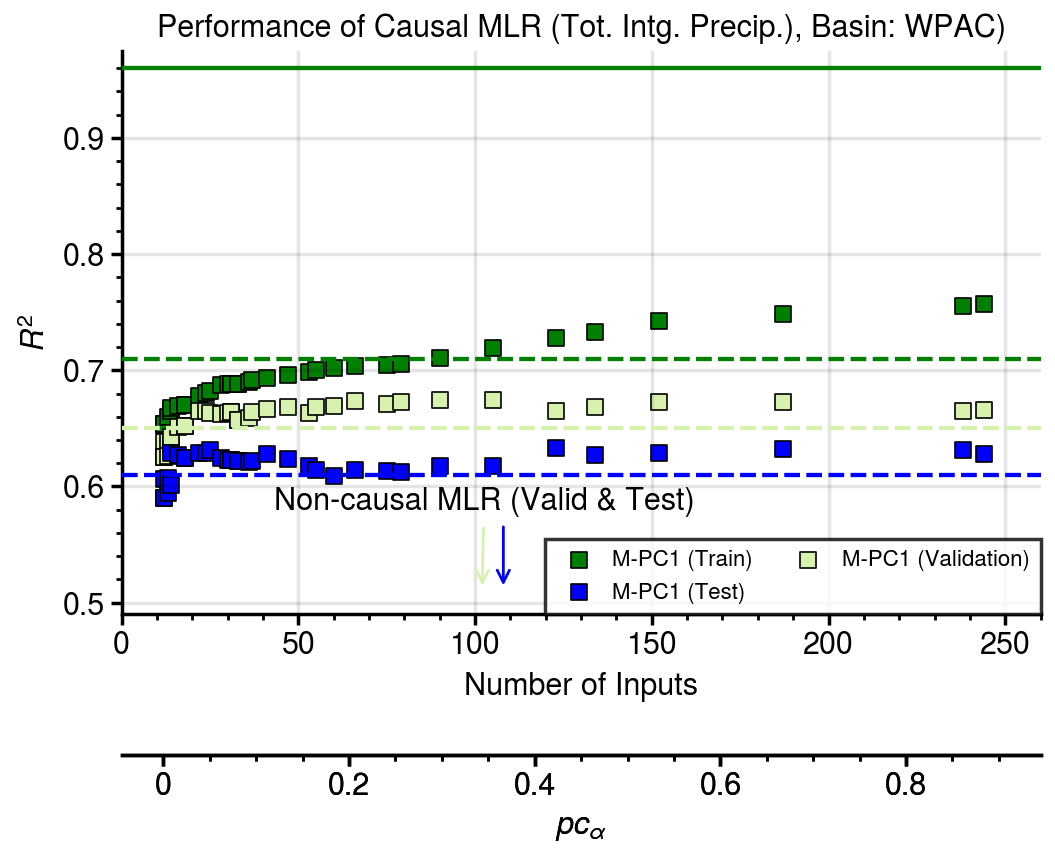

In [66]:
fig,ax = plot.subplots(nrows=1,ncols=1,axwidth=4.595,refaspect=1.631)
ax2 = ax[0].twiny()
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

#ax[0].scatter(np.asarray(pcmci_wpac_2tau16['size']).flatten(),np.asarray(pcmci_wpac_2tau16['r2_train']).flatten(),\
#            s=20,label='M-PCMCI (Training)',edgecolor='k',alpha=0.6)
ax[0].scatter(np.asarray(pcstable_wpac_2tau16['size']).flatten(),np.asarray(pcstable_wpac_2tau16['r2_train']).flatten(),\
            s=30,label='M-PC1 (Train)',edgecolor='k',marker='s',color='g')
#ax[0].scatter(np.asarray(pcmci_wpac_2tau16['size']).flatten(),np.asarray(pcmci_wpac_2tau16['r2_test']).flatten(),\
#            s=20,label='M-PCMCI (Validation)',edgecolor='k',alpha=0.6)
ax[0].scatter(np.asarray(pcstable_wpac_2tau16['size']).flatten(),np.asarray(pcstable_wpac_2tau16['r2_test_old']).flatten(),\
            s=30,label='M-PC1 (Validation)',edgecolor='k',marker='s',color='#d7f2ae')
ax[0].scatter(np.asarray(pcstable_wpac_2tau16['size']).flatten(),np.asarray(pcstable_wpac_2tau16['r2_test_new']).flatten(),\
            s=30,label='M-PC1 (Test)',edgecolor='k',marker='s',color='b')

ax2.scatter(pc_alphalist,np.asarray(pcstable_wpac_2tau16['r2_test_old']).flatten(),alpha=0)
#ax[0].format(rtitle='Training')
#ax[1].format(rtitle='Validation')
ax.format(ylabel='$\it{R^{2}}$',xlabel='Number of Inputs',
          #ltitle=f'Performance of 1 day lead time (Minimum SLP), Basin: WPAC)',
          xlim=[0,260],ylim=[0.49,0.975]) #vmax: [0.66,0.995]; pmin: [0.66,0.995] precip [0.49,0.975]
ax.set_title(f'Performance of Causal MLR (Tot. Intg. Precip.), Basin: WPAC)',fontsize=11,loc='center')
ax.legend(loc=4,ncol=2,prop={'size':8})
#ax.grid(alpha=0.2,lw=1.5,ls='-.')
# Spines
#ax.spines.left.set_position(('outward', 10))
#ax.spines.bottom.set_position(('outward', 10))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines.top.set_visible(False)
ax2.spines['bottom'].set_position(("axes",-0.25))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
ax2.axhline(y=0.96, color="g", linestyle="-", label='Noncausal MLR (Train)')
#ax2.axhline(y=0.51, color="g", linestyle="-", label='Noncausal MLR (Test)')
ax2.axhline(y=0.71, color="g", linestyle="--", label='LSTM (Train)')
ax2.axhline(y=0.65, color="#d7f2ae", linestyle="--", label='LSTM (Valid)')
ax2.axhline(y=0.61, color="b", linestyle="--", label='LSTM (Test)')

ax[0].annotate("Non-causal MLR (Valid & Test)", xy=(102, 0.51),xytext=(43, 0.58) , arrowprops=dict(arrowstyle='->',lw=1,color='#d7f2ae'))
ax.annotate("", xy=(108, 0.51), xytext=(108, 0.57),arrowprops=dict(arrowstyle="->",lw=1,color='b'))
#ax[0].text(right, top, 'right top', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)


for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.set_xlabel(r"$\it{pc_{\alpha}}$")
plt.tight_layout()
plt.savefig('./plots_output/fig2_revised_8_24_pc1_precip.png',dpi=600,facecolor='w')
plt.show()

# Random Forest Regression

In [69]:
def give_r2_aligned_rf(filelist=None,alt_filelist=None):
    store_r2train,store_r2test_old,store_r2test_new,store_size = [],[],[],[]
    files = [depickle(obj) for obj in filelist]
    fileXy = [depickle(obj) for obj in alt_filelist]
    for ind,file in enumerate(files):
        temp_r2train = r2_score(fileXy[ind]['y']['train'],file.predict(fileXy[ind]['X']['train']))
        temp_r2test_old = r2_score(fileXy[ind]['y']['valid']+fileXy[ind]['y']['test'],file.predict(fileXy[ind]['X']['valid']+fileXy[ind]['X']['test']))
        temp_r2test_new = r2_score(fileXy[ind]['y']['newtest'],file.predict(fileXy[ind]['X']['newtest']))
        temp = np.asarray([list(obj) for obj in fileXy[ind]['X']['train']]).shape[1]
        store_r2train.append(temp_r2train)
        store_r2test_old.append(temp_r2test_old)
        store_r2test_new.append(temp_r2test_new)
        store_size.append(temp)
    storedict_pcstable = {'r2_train':store_r2train,'r2_test_old':store_r2test_old,'r2_test_new':store_r2test_new,'size':store_size}
    del store_r2train,store_r2test_old,store_r2test_new,store_size
    return storedict_pcstable

In [95]:
from natsort import natsorted
#####################################################################################################################################
# Read files (PC1)
listtt = sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/rf/*precip*'))
# Wrong order to correct...
aligned2_16_list = [listtt[-1],listtt[-4],listtt[-2],listtt[-5],listtt[-3],listtt[-6]]
for obj in listtt[:-6]:
    aligned2_16_list.append(obj)
#####################################################################################################################################
# Read files (PC1)
listtt_mlr = (sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/parallel_tigramite/newdata/pcstablewpac_aligned_8-24_precip*')))
# Wrong order to correct...

aligned2_16_list_mlr = [listtt_mlr[-1],listtt_mlr[-4],listtt_mlr[-2],listtt_mlr[-5],listtt_mlr[-3],listtt_mlr[-6]]
for obj in listtt_mlr[:-6]:
    aligned2_16_list_mlr.append(obj)
##################################################################################################################################### 
#pcmci_wpac_2tau16 = give_r2()
pcstable_wpac_2tau16 = give_r2_aligned_rf(aligned2_16_list,aligned2_16_list_mlr)

In [96]:
pc_alphalist = [1e-7,1.5e-7,1e-6,1.5e-6,1e-5,1.5e-5,0.0001,0.00015,0.001,0.0015,0.01,0.015,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,\
                  0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.86,0.88,0.9]

/tmp/ipykernel_2076914/3617911721.py:42: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


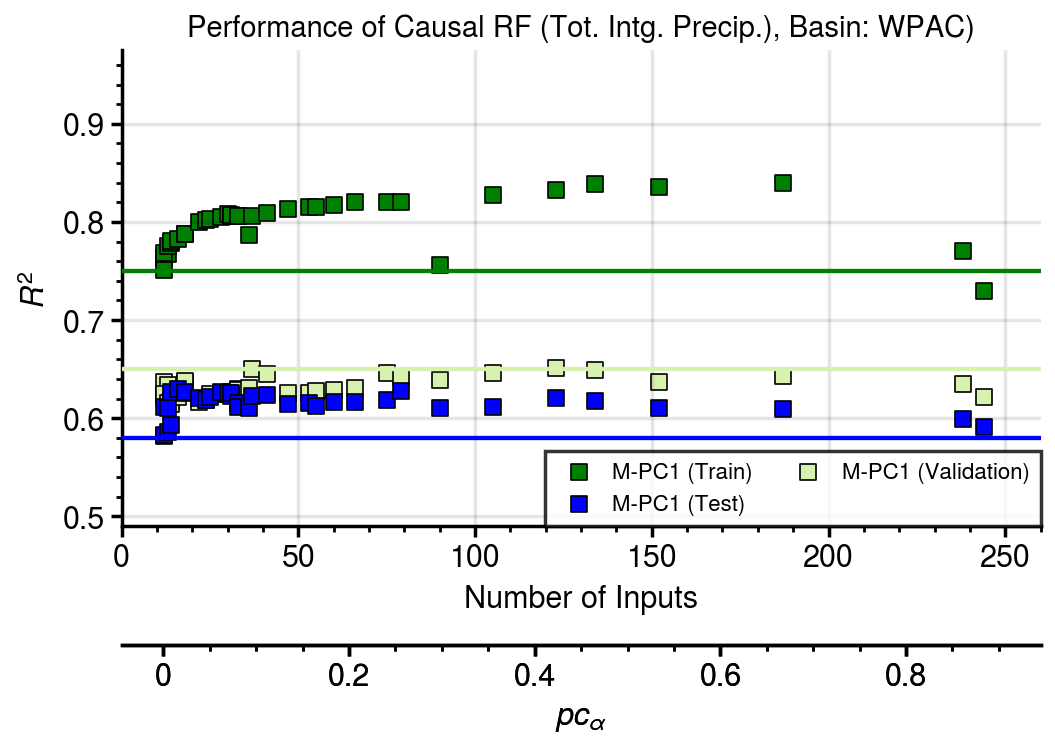

In [98]:
fig,ax = plot.subplots(nrows=1,ncols=1,axwidth=4.595,refaspect=1.931)
ax2 = ax[0].twiny()
#ax[0].scatter(np.asarray(pcmci_wpac_2tau16['size']).flatten(),np.asarray(pcmci_wpac_2tau16['r2_train']).flatten(),\
#            s=20,label='M-PCMCI (Training)',edgecolor='k',alpha=0.6)
ax[0].scatter(np.asarray(pcstable_wpac_2tau16['size']).flatten(),np.asarray(pcstable_wpac_2tau16['r2_train']).flatten(),\
            s=30,label='M-PC1 (Train)',edgecolor='k',marker='s',color='g')
#ax[0].scatter(np.asarray(pcmci_wpac_2tau16['size']).flatten(),np.asarray(pcmci_wpac_2tau16['r2_test']).flatten(),\
#            s=20,label='M-PCMCI (Validation)',edgecolor='k',alpha=0.6)
ax[0].scatter(np.asarray(pcstable_wpac_2tau16['size']).flatten(),np.asarray(pcstable_wpac_2tau16['r2_test_old']).flatten(),\
            s=30,label='M-PC1 (Validation)',edgecolor='k',marker='s',color='#d7f2ae')
ax[0].scatter(np.asarray(pcstable_wpac_2tau16['size']).flatten(),np.asarray(pcstable_wpac_2tau16['r2_test_new']).flatten(),\
            s=30,label='M-PC1 (Test)',edgecolor='k',marker='s',color='b')
ax2.scatter(pc_alphalist,np.asarray(pcstable_wpac_2tau16['r2_test_old']).flatten(),alpha=0)
#ax[0].format(rtitle='Training')
#ax[1].format(rtitle='Validation')
ax.format(ylabel='$\it{R^{2}}$',xlabel='Number of Inputs',
          #ltitle=f'Performance of 1 day lead time (Minimum SLP), Basin: WPAC)',
          xlim=[0,260],ylim=[0.49,0.975]) #vmax: pmin: [0.66,0.995]; precip:[0.49,0.975] -
ax.set_title(f'Performance of Causal RF (Tot. Intg. Precip.), Basin: WPAC)',fontsize=10.5,loc='center')
ax.legend(loc=4,ncol=2,prop={'size':8})
#ax.grid(alpha=0.2,lw=1.5,ls='--')
# Spines
#ax.spines.left.set_position(('outward', 10))
#ax.spines.bottom.set_position(('outward', 10))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines.top.set_visible(False)
ax2.spines['bottom'].set_position(("axes",-0.25))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
#ax2.axhline(y=0.77, color="firebrick", linestyle="-")
ax2.axhline(y=0.75, color="g", linestyle="-", label='Noncausal RF (Train)')
ax2.axhline(y=0.65, color="#d7f2ae", linestyle="-", label='Noncausal RF (Valid)')
ax2.axhline(y=0.58, color="b", linestyle="-", label='Noncausal RF (Test)')

for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.set_xlabel(r"$\it{pc_{\alpha}}$")
plt.tight_layout()
plt.savefig('./plots_output/fig2_final_8_24_pc1_precip_rf.png',dpi=600,facecolor='w')
plt.show()

In [139]:
import cmaps

/tmp/ipykernel_1504482/2815147490.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = ax.pcolormesh(np.asarray(pcmci_wpac_2tau16_fig2['r2_test']),cmap=cmaps.hotcold_18lev,vmin=vmin,vmax=vmax,label='$R^2$')
/tmp/ipykernel_1504482/2815147490.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(img,label='$R^2$')


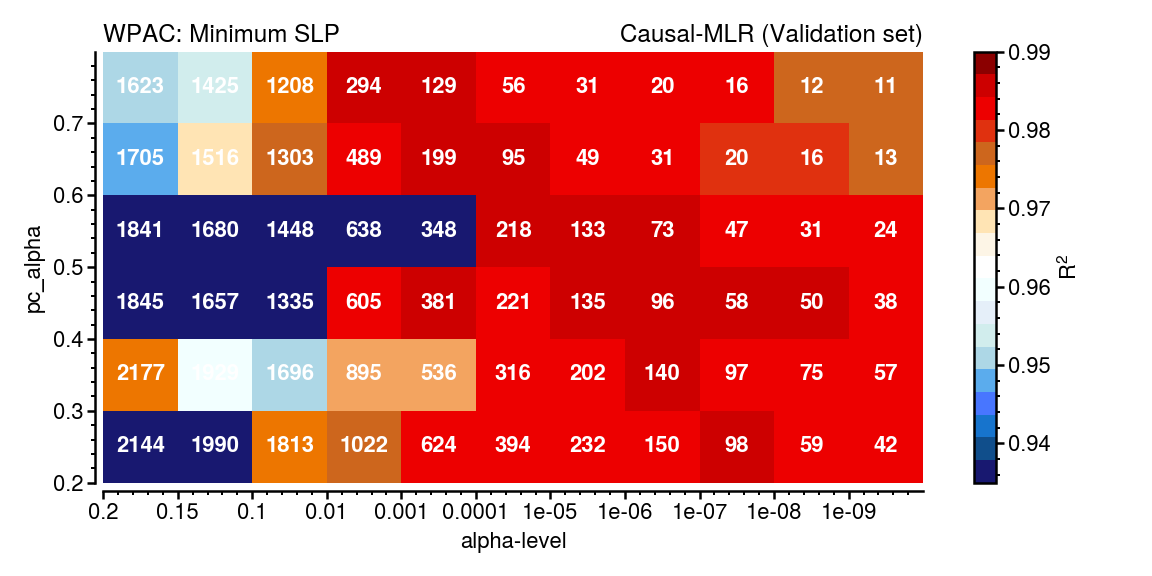

In [209]:
vmax=0.99#(pmin) 0.99 #(vmin) 0.95  #(precip) 0.92
vmin=0.935#(pmin) 0.935 #(vmin) 0.88 #(precip) 0.65
fig,ax = plt.subplots(1,1,figsize=(8,4))
img = ax.pcolormesh(np.asarray(pcmci_wpac_2tau16_fig2['r2_test']),cmap=cmaps.hotcold_18lev,vmin=vmin,vmax=vmax,label='$R^2$')
for y in range(np.asarray(pcmci_wpac_2tau16_fig2['size']).shape[0]):
    for x in range(np.asarray(pcmci_wpac_2tau16_fig2['size']).shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.0f' % np.asarray(pcmci_wpac_2tau16_fig2['size'])[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',color='white',fontweight='semibold'
                 )
        
ax.set_xticks(np.linspace(0,10,11))
ax.set_xticklabels([0.2,0.15,0.1,0.01,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9])
ax.set_yticks(np.linspace(0,5,6))
ax.set_yticklabels([0.2,0.3,0.4,0.5,0.6,0.7])
ax.set_xlabel('alpha-level')
ax.set_ylabel('pc_alpha')
ax.set_title('WPAC: Minimum SLP',loc='left')
ax.set_title('Causal-MLR (Validation set)',loc='right')
cbar = plt.colorbar(img,label='$R^2$')
#cbar.set_ticks([100,200,300,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000])
ax.spines.left.set_position(('outward', 4))
ax.spines.bottom.set_position(('outward', 4))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tight_layout()
plt.savefig('./plots_output/2d_wpacpmin_fig2.png',dpi=600,facecolor='w')
plt.show()

#### Figure 3

In [108]:
random_wpac_2tau16 = give_r2_random()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:34:50<00:00, 56.90s/it]


In [27]:
np.asarray(rfreg_wpac_2tau16['r2_train']).flatten()

array([], dtype=float64)

/tmp/ipykernel_2768671/2527842487.py:33: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


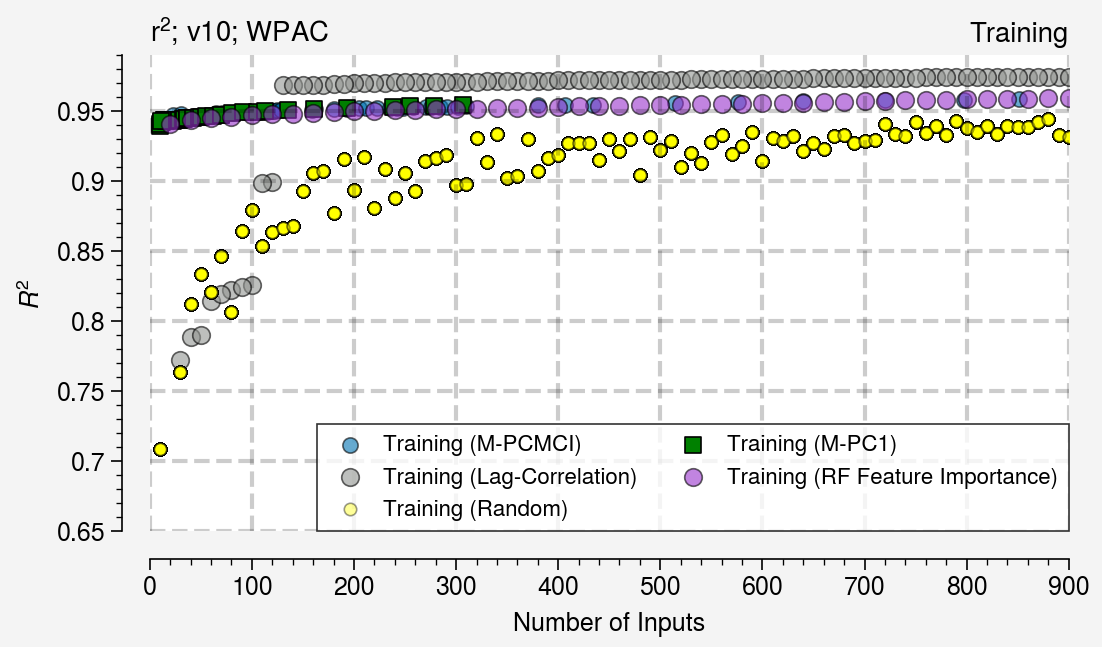

In [31]:
fig,ax = plot.subplots(nrows=1,ncols=1,axwidth=4.595,refaspect=1.931)
ax[0].scatter(np.asarray(pcmci_wpac_2tau16['size']).flatten(),np.asarray(pcmci_wpac_2tau16['r2_train']).flatten(),\
            s=30,label='Training (M-PCMCI)',edgecolor='k',alpha=0.6)
ax[0].scatter(np.asarray(pcstable_wpac_2tau16['size']).flatten(),np.asarray(pcstable_wpac_2tau16['r2_train']).flatten(),\
            s=30,label='Training (M-PC1)',edgecolor='k',marker='s',color='g')
ax[0].scatter(np.asarray(lag_wpac_2tau16['size']).flatten(),np.asarray(lag_wpac_2tau16['r2_train']).flatten(),
            s=40,label='Training (Lag-Correlation)',edgecolor='k',alpha=0.6,c='gray')
ax[0].scatter(np.asarray(rfreg_wpac_2tau16['size']).flatten(),np.asarray(rfreg_wpac_2tau16['r2_train']).flatten(),
            s=40,label='Training (RF Feature Importance)',edgecolor='k',alpha=0.6,c='darkorchid')
ax[0].scatter(np.asarray(random_wpac_8tau24['size']).flatten(),np.asarray(random_wpac_8tau24['r2_train']).flatten(),
            s=20,label='Training (Random)',edgecolor='k',alpha=0.4,c='yellow',marker='o')
#ax[0].scatter(np.asarray(pcmci_wpac_2tau16['size']).flatten(),np.asarray(pcmci_wpac_2tau16['r2_test']).flatten(),\
#            s=20,label='M-PCMCI (Validation)',edgecolor='k',alpha=0.6)
#ax[0].scatter(np.asarray(pcstable_wpac_2tau16['size']).flatten(),np.asarray(pcstable_wpac_2tau16['r2_test']).flatten(),\
#            s=30,label='M-PC1 (Validation)',edgecolor='k',marker='s',color='#d7f2ae')

#plt.scatter(np.asarray(random_wpac_2tau16['size']).flatten(),np.asarray(random_wpac_2tau16['r2_train']).flatten(),
#            s=40,label='Training (random)',edgecolor='k',alpha=0.6,c='yellow',marker='o')
#plt.scatter(np.asarray(random_wpac_2tau16['size']).flatten(),np.asarray(random_wpac_2tau16['r2_test']).flatten(),
#            s=40,label='Validation (random)',edgecolor='k',alpha=0.6,c='green',marker='o')
#plt.scatter(np.asarray(lag_wpac_2tau16['size']).flatten(),np.asarray(lag_wpac_2tau16['r2_test']).flatten(),
#            s=40,label='Test (Lag-Correlation)',edgecolor='k',alpha=0.6,c='m',marker='*')
#ax[0].format(rtitle='Training')
#ax[1].format(rtitle='Validation')
ax.format(ylabel='$\it{R^{2}}$',xlabel='Number of Inputs',ltitle=f'$r^2$; v10; WPAC',xlim=[0,900],ylim=[0.65,.99],rtitle='Training')#ylim=[0.705,0.946])
ax.legend(loc=4,ncol=2,prop={'size':8})
ax.grid(alpha=0.2,lw=1.5,ls='--')
# Spines
ax.spines.left.set_position(('outward', 10))
ax.spines.bottom.set_position(('outward', 10))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tight_layout()
plt.savefig('./plots_output/fig3_training_v10.png',dpi=600,facecolor='w')
plt.show()

## Not Aligned

In [11]:
pcmci_wpac_2tau16 = give_r2()
pcstable_wpac_2tau16 = give_r2_pcstable()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.89it/s]


In [13]:
lag_wpac_2tau16 = give_r2_lag()

In [5]:
sorted(glob.glob('./pickleddata_random/12348/*2_16_pmin*'))

['./pickleddata_random/12348/randomwpac2_2_16_pmin.obj.1000.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.610.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.620.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.630.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.640.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.650.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.660.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.670.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.680.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.690.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.700.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.710.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.720.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.730.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj.740.0',
 './pickleddata_random/12348/randomwpac2_2_16_pmin.obj

In [6]:
pc_alpha=[0.2,0.1,0.05,0.01,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
alpha_level = [0.2,0.15,0.1,0.01,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9]

In [16]:
pmin_trained = [depickle(obj) for obj in sorted(glob.glob('./combinedscript/pickleddata3/12348/*v10*'))]

In [17]:
import pandas as pd
numVAR = pd.DataFrame({'numVAR':[np.asarray(pmin_trained[i]['X']['train']).shape[1] for i in range(20)]})
expINDEX = (numVAR.sort_values(by=['numVAR']).index)

#### R2 score

In [20]:
numVAR.sort_values(by=['numVAR'])

,numVAR
19,164
13,183
18,242
12,256
17,321
11,345
16,416
10,438
15,521
9,573


In [21]:
from sklearn.metrics import r2_score,mean_squared_error
r2_train = [r2_score(pmin_trained[obj]['y']['train'],\
                               pmin_trained[obj]['mlr'].predict(pmin_trained[obj]['X']['train'])) for obj in expINDEX]
r2_test = [r2_score(pmin_trained[obj]['y']['test'],\
                              pmin_trained[obj]['mlr'].predict(pmin_trained[obj]['X']['test'])) for obj in expINDEX]

In [23]:
np.asarray(pmin_trained[19]['y']['train']).shape

(1218,)

In [24]:
r2_score(np.asarray(pmin_trained[19]['y']['test']),\
         np.asarray(pmin_trained[19]['mlr'].predict(pmin_trained[19]['X']['test'])))

0.8630401546843401

#### Convert links to text

In [27]:
def convert_to_text(obj=None):
    emptylist = []
    for subobj in obj:
        emptylist.append((varname[subobj[0]],subobj[1]))
    return emptylist
def write_to_txt(listloc=None,a_list=None):
    textfile = open(listloc, "w")
    for element in a_list:
        textfile.write(str(element) + "\n")
    textfile.close()

target = ['precip','pmin','v10']
for ind,obj in enumerate(lag_and_links):
    mylist = convert_to_text(obj)
    write_to_txt('./links_'+str(target[ind])+'_0.05.txt',mylist)

In [28]:
precipvars,preciplags =[obj[0] for obj in convert_to_text(lag_and_links[0])],\
[obj[1] for obj in convert_to_text(lag_and_links[0])]
preciplinksDF = pd.DataFrame(data={'varname':precipvars,'lags':preciplags})

IndexError: list index out of range

In [29]:
preciplinksDF

NameError: name 'preciplinksDF' is not defined

#### Plot results